In [1]:
# Set up and load data
# Includes
import sys
import os
import numpy as np
import json
import os


# Setup paths containing utility
curr_folder = os.getcwd()
sys.path.insert(0, os.path.join(curr_folder,'../../../app'))

# Utils imports for loading data
from utils import save_data, load_data, exists_datafolder
from utils import load_SQuAD_train, load_SQuAD_dev
from utils import get_foldername
from utils_NLP import text2sentences,words2words_blanked
from utils_SQuAD import OR_arts_paragraph_fields,merge_arts_paragraph_fields

# Plotting includes
from utils_EDAplots import plotbar_train_dev,plothist_train_dev,plotbar_train_dev2,plothist_train_dev2


# Import fig stuff
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# Option for merging NER data into combined model
merge_in_NER_data = False

# Load and merge ground truth and MODEL data

In [3]:
# Load data containing MODEL (predictions)
foldername = os.path.join('SQ_pp_b4m0c2')
arts_train = load_data('train.json',foldername,prepend_data_folder=False)
arts_dev = load_data('dev.json',foldername,prepend_data_folder=False)

# All articles
Ntrain = len(arts_train)
Ndev = len(arts_dev)

arts = arts_train + arts_dev
print(arts[1]['title'])
# print(arts[1]['paragraphs'][0]['context'])

Frédéric_Chopin


In [4]:
# Load blanks data (ground truth)
foldername = get_foldername('sq_pp_training')
arts3 = load_data('train.json',foldername) + load_data('dev.json',foldername)
print(arts3[1]['title'])
# print(arts3[1]['paragraphs'][0]['context_blanked'])


Frédéric_Chopin


In [5]:
# Make sure all titles match
all_title_pairs = [(a1['title'],a3['title']) for a1,a3 in zip(arts,arts3)]
titles_match_bool = [a1['title'] == a3['title'] for a1,a3 in zip(arts,arts3)]
print("Matching titles: {} \nTotal articles {}".format(sum(titles_match_bool),len(titles_match_bool)))

Matching titles: 477 
Total articles 477


In [6]:
# Merge ground truth blanks with original data to get full dataset
list_of_fields = ['context_blanked','blank_classification']
arts = merge_arts_paragraph_fields(arts,arts3,list_of_fields)

# print(arts[1]['title'])
# print(arts[1]['paragraphs'][0]['context'])
# print(arts[1]['paragraphs'][0]['context_blanked'])

In [7]:
arts[105]['paragraphs'][0]['context']

"Pitch is an auditory sensation in which a listener assigns musical tones to relative positions on a musical scale based primarily on their perception of the frequency of vibration. Pitch is closely related to frequency, but the two are not equivalent. Frequency is an objective, scientific attribute that can be measured. Pitch is each person's subjective perception of a sound, which cannot be directly measured. However, this does not necessarily mean that most people won't agree on which notes are higher and lower."

In [8]:
# Convert AllenNLP Model blanks classification into standard format

# If doing merge, use unique name for this model result. Otherwise, use generic name
if merge_in_NER_data: fieldname = 'blank_classified_allenMODEL'
else: fieldname = 'blank_classified_allen'


from utils_NLP import allenNLP_classify_blanks
arts = allenNLP_classify_blanks(arts,'0',fieldname)
arts[0]['paragraphs'][0].keys()

dict_keys(['qas', 'context', 'allenNER', 'context_blanked', 'blank_classification', 'blank_classified_allen'])

# Load NER data and merge into arts dataset

In [9]:

if merge_in_NER_data:
    # Load data containing NEP (predictions)
    foldername = get_foldername('sq_pp_ner')

    arts_NER = load_data('train.json',foldername) + load_data('dev.json',foldername)
    print(arts[1]['title'])
    # print(arts[1]['paragraphs'][0]['context'])

    # Make sure all titles match
    all_title_pairs = [(a1['title'],a3['title']) for a1,a3 in zip(arts,arts_NER)]
    titles_match_bool = [a1['title'] == a3['title'] for a1,a3 in zip(arts,arts_NER)]
    print("Matching titles: {} \nTotal articles {}".format(sum(titles_match_bool),len(titles_match_bool)))

    # Convert AllenNLP Model blanks classification into standard format
    from utils_NLP import allenNLP_classify_blanks
    arts_NER = allenNLP_classify_blanks(arts_NER,'O','blank_classified_allenNER')
    print(arts_NER[0]['paragraphs'][0].keys())

    # Merge NER data into full dataset
    list_of_fields = ['blank_classified_allenNER']
    arts = merge_arts_paragraph_fields(arts,arts_NER,list_of_fields)
    print(arts[0]['paragraphs'][0].keys())

In [10]:
# OR operation on blank_classified_allenMODEL and blank_classified_allenNER into blank_classified_allenMODEL

if merge_in_NER_data:
    destination_fieldname = 'blank_classified_allen'
    arts = OR_arts_paragraph_fields(arts,['blank_classified_allenMODEL','blank_classified_allenNER'],destination_fieldname)

    p = arts[0]['paragraphs'][1]
    print(p['blank_classified_allenNER'])
    print(p['blank_classified_allenMODEL'])
    print(p['blank_classified_allen'])


# Compare paragraph word reconstructions

This just looks at the words in the different saved fiels files to make sure all the words match up 1:1 (otherwise, this could mess up our evaluations). Not looking at blanks here at all. The next sectoin looks at the blanks

In [11]:
# Pull out sample paragraph
p = arts[1]['paragraphs'][0]

## AllenNLP Words

In [12]:
from utils_NLP import words2text
words = p['allenNER']['words'].split()
tags = p['allenNER']['tags'].split()
print(len(words))
print(len(tags))
print(words2text(words))
print(len(words2text(words)))

164
164
Frédéric François Chopin ( /ˈʃoʊpæn/; French pronunciation : ​[fʁe.de.ʁik fʁɑ̃.swa ʃɔ.pɛ̃ ]; 22 February or 1 March 1810 – 17 October 1849 ), born Fryderyk Franciszek Chopin,[n 1 ] was a Polish and French ( by citizenship and birth of father ) composer and a virtuoso pianist of the Romantic era, who wrote primarily for the solo piano. He gained and has maintained renown worldwide as one of the leading musicians of his era, whose " poetic genius was based on a professional technique that was without equal in his generation. " Chopin was born in what was then the Duchy of Warsaw, and grew up in Warsaw, which after 1815 became part of Congress Poland. A child prodigy, he completed his musical education and composed his earlier works in Warsaw before leaving Poland at the age of 20, less than a month before the outbreak of the November 1830 Uprising.
858


## Context

In [13]:
from utils_NLP import allenNLP_split_words, join_punctuation

context = p['context']
context_split = allenNLP_split_words(context)

# context_reassembled = ' '.join(context_split)
context_reassembled = words2text(context_split)

print(len(context_split))
# print(words2text(context_split))
# print(len(words2text(context_split)))
print(context_reassembled)
print(len(context_reassembled))


164
Frédéric François Chopin ( /ˈʃoʊpæn/; French pronunciation : ​[fʁe.de.ʁik fʁɑ̃.swa ʃɔ.pɛ̃ ]; 22 February or 1 March 1810 – 17 October 1849 ), born Fryderyk Franciszek Chopin,[n 1 ] was a Polish and French ( by citizenship and birth of father ) composer and a virtuoso pianist of the Romantic era, who wrote primarily for the solo piano. He gained and has maintained renown worldwide as one of the leading musicians of his era, whose " poetic genius was based on a professional technique that was without equal in his generation. " Chopin was born in what was then the Duchy of Warsaw, and grew up in Warsaw, which after 1815 became part of Congress Poland. A child prodigy, he completed his musical education and composed his earlier works in Warsaw before leaving Poland at the age of 20, less than a month before the outbreak of the November 1830 Uprising.
858


## Context_blanked

In [14]:
print(len(p['blank_classification']))
print(p.keys())
print(p['context_blanked'])

164
dict_keys(['qas', 'context', 'allenNER', 'context_blanked', 'blank_classification', 'blank_classified_allen'])
Frédéric François Chopin ( /ˈʃoʊpæn/ ; ______ pronunciation : ​[fʁe.de.ʁik fʁɑ̃.swa ʃɔ.pɛ̃ ] ; 22 February or 1 March ______ – 17 October ______ ) , born Fryderyk Franciszek Chopin,[n 1 ] was a ______ and ______ ( by citizenship and birth of father ) composer and a virtuoso pianist of the ______ ______ , who wrote primarily for the ______ ______ . He gained and has maintained renown worldwide as one of the leading musicians of his ______ , whose " poetic genius was based on a professional technique that was without equal in his generation . " Chopin was born in what was then the ______ of ______ , and grew up in ______ , which after 1815 became part of Congress Poland . A child prodigy , he completed his musical education and composed his earlier works in ______ before leaving Poland at the age of ______ , less than a month before the outbreak of the November 1830 Uprising

In [15]:
# Answers
for i,c in enumerate(p['blank_classification']):
    if c == 1: print(context_split[i])

French
1810
1849
Polish
French
Romantic
era
solo
piano
era
Duchy
Warsaw
Warsaw
Warsaw
20


# Single paragraph - Compare blanks

## First, just look at the raw text

In [169]:
# Pull out sample paragraph
p = arts[0]['paragraphs'][1]

# # Print all AllenNLP classifications
# print([(a,b) for a,b in zip(p['allenNER']['words'].split(), p['allenNER']['tags'].split())])

# AllenNLP results
words = p['allenNER']['words'].split()
# tags = p['allenNER']['tags'].split()
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = p['blank_classified_allen']

# Ground truth
blank_classification = p['blank_classification']

In [170]:


print("Length Allen tags: {}. Length ground truth blanks: {}".format(len(tags),len(blank_classification)))

Length Allen tags: 215. Length ground truth blanks: 215


In [171]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
Following				Following
the				the
disbandment				disbandment
of				of
Destiny				Destiny
's				's
Child				Child
in				in
______				______
______				______
,				,
she				she
released				released
her				her
second				second
solo				solo
album				album
,				,
______				B'Day
(				(


## Ground truth blanked

In [172]:
# Blanked text
print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(myanswers)

Following the disbandment of Destiny 's Child in ______ ______, she released her second solo album, ______ ( 2006 ), which contained hits " Déjà Vu ", " Irreplaceable ", and " Beautiful Liar ". ______ also ventured into ______, with a Golden Globe - nominated performance in ______ ( 2006 ), and starring roles in The Pink Panther ( 2006 ) and Obsessed ( 2009 ). Her marriage to rapper ______ ______ and portrayal of Etta James in ______ ______ ( 2008 ) influenced her third album, I Am ... ______ ______ ( 2008 ), which saw the birth of her alter - ego ______ ______ and earned a record - setting ______ Grammy Awards in ______, including Song of the Year for " Single Ladies ( Put a Ring on It ) ". ______ took a hiatus from music in ______ and took over management of her career; her fourth album 4 ( 2011 ) was subsequently mellower in tone, exploring 1970s funk, 1980s pop, and 1990s soul. Her critically acclaimed fifth studio album, ______ ( 2013 ), was distinguished from previous releases by

In [173]:
# Blanked text
print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(myanswers)

Following the disbandment of Destiny 's Child in ______ ______, she released her second solo album, B'Day ( 2006 ), which contained hits " Déjà Vu ", " Irreplaceable ", and " Beautiful Liar ". Beyoncé also ventured into acting, with a Golden Globe - nominated performance in Dreamgirls ( 2006 ), and starring roles in The Pink Panther ( 2006 ) and Obsessed ( 2009 ). Her marriage to rapper Jay Z and portrayal of Etta James in Cadillac Records ( 2008 ) influenced her third album, I Am ... Sasha Fierce ( 2008 ), which saw the birth of her alter - ego Sasha Fierce and earned a record - setting six Grammy Awards in 2010, including Song of the Year for " Single Ladies ( Put a Ring on It ) ". Beyoncé took a hiatus from music in 2010 and took over management of her career; her fourth album 4 ( 2011 ) was subsequently mellower in tone, exploring 1970s funk, 1980s pop, and 1990s soul. Her critically acclaimed fifth studio album, ______ ( 2013 ), was distinguished from previous releases by its expe

In [174]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [175]:
print(ACC)
print(ACC2)
print(TP)
print(FP)

0.9255813953488372
0.9255813953488372
3
0


In [176]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [177]:
print(TPR)
print(FPR)

0.15789473684210525
0.0


In [178]:
Nsentences = len(text2sentences(p['context']))
print("Nsentences={}".format(str(Nsentences)))

Nsentences2 = len(text2sentences(words2text(words)))
print("Nsentences_from_words={}".format(str(Nsentences2)))



Nsentences=5
Nsentences_from_words=5


In [179]:
TPpersent = TP / Nsentences2
FPpersent = FP / Nsentences2

print(TPpersent)
print(FPpersent)

0.6
0.0


# Single article - compare blanks

In [194]:
# Pull out sample paragraph
a = arts[105]
print(a['title'])

# AllenNLP results
words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
# tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

# Ground truth
blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]

Pitch_(music)


In [195]:

print("Length Allen tags: {}. Length ground truth blanks: {}".format(len(tags),len(blank_classification)))

Length Allen tags: 1482. Length ground truth blanks: 1482


In [196]:
# Side by side compare
words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
______				Pitch
is				is
an				an
______				auditory
sensation				sensation
in				in
which				which
a				a
listener				listener
assigns				assigns
musical				musical
tones				tones
to				to
relative				relative
positions				positions
on				on
a				a
musical				musical
scale				scale
based				based


In [197]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [198]:
print(ACC)
print(ACC2)

0.9601889338731444
0.9601889338731444


In [199]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [200]:
print(TPR)
print(FPR)

0.05084745762711865
0.0021082220660576245


In [201]:
Nsentences2 = len(text2sentences(words2text(words)))
print("Nsentences_from_words={}".format(str(Nsentences2)))

Nsentences_from_words=53


In [202]:
TPpersent = TP / Nsentences2
FPpersent = FP / Nsentences2

print(TPpersent)
print(FPpersent)

0.05660377358490566
0.05660377358490566


## Ground truth blanked

In [212]:
# Blanked text
# print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(set(myanswers))

Answers:
{'ambiguities', '69', 'indefinite', 'A4', 'Pitch', 'missing', 'generated', '1', 'partials', 'auditory', '1,400', '60.5', 'two', 'sound', 'slower', 'ambiguous', '12', 'drum', 'numerical', 'Frequency', 'overtones', 'snare', 'pitch', 'numerous', 'fundamental', 'spelling', 'logarithmic', 'rapid', 'frequency', 'unnecessary', '100', 'octave'}


In [213]:
# Blanked text
# print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(set(myanswers))

Answers:
{'60.5', 'fundamental', '880', 'frequency', 'partials', 'pitch'}


# All articles - compare blanks

In [254]:
# Initialize stuff
TPR0 = []
FPR0 = []
ACC0 = []
Nsentences0 = []
TP0 = []
FP0 = []
FN0 = []
TN0 = []
TPpersent0 = []
FPpersent0 = []
abads = []            # Article-level bads

art = arts[:]

i=-1
for a in art:
    i=i+1
    # AllenNLP results
    words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
#     tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
#     tags = [not t == '0' for t in tags]   # Convert to binary
    tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

    # Ground truth
    blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]
    blank_classification = [b == 1 for b in blank_classification] # Convert to binary

    Nsentences2 = len(text2sentences(words2text(words)))
    
    sbc = sum(blank_classification)
    st = sum(tags)
    if sbc == 0 or st == 0:
        print("Warning article {} contains {} ground truth blanks and {} tags. Likely bad".format(str(i),str(sbc),str(st)))
        
        # Make up some dummy values so don't confuse for a REAL outlier in plots. Should just drop this data in the future
        # This is ok because we'll skip them later if want to do stats - that's what abads is for
        TPR = 0.0
        FPR = 0.0
        ACC = 0.0
        TP = 100
        FP = 100
        FN = 100
        TN = 100
        
        TPpersent = 1
        FPpersent = 1
        abads.append(i)
    else:
        TP = sum([b and t for b,t in zip(blank_classification,tags)])
        FP = sum([not b and t for b,t in zip(blank_classification,tags)])
        FN = sum([b and not t for b,t in zip(blank_classification,tags)])
        TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
        ACC = (TP+TN)/(TP+FP+FN+TN)
        ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)
        
        # Per sententance values
        TPpersent = TP / Nsentences2
        FPpersent = FP / Nsentences2
    
    TPR0.append(TPR)
    FPR0.append(FPR)
    ACC0.append(ACC)
    TP0.append(TP)
    FP0.append(FP)
    FN0.append(FN)
    TN0.append(TN)
    TPpersent0.append(TPpersent)
    FPpersent0.append(FPpersent)
    



Warning article 175 contains 0 ground truth blanks and 13 tags. Likely bad
Warning article 245 contains 118 ground truth blanks and 0 tags. Likely bad
Warning article 440 contains 0 ground truth blanks and 2 tags. Likely bad
Warning article 441 contains 0 ground truth blanks and 8 tags. Likely bad


In [255]:
# Print tiles of bad articles
for ab in abads:
    print(art[ab]['title'])

Bill_%26_Melinda_Gates_Foundation
Glacier
Myocardial_infarction
Matter


In [256]:
# Calculate how this affects Ntrain / Ndev
Ntrain_bad = len([b for b in abads if b < Ntrain])
Ndev_bad = len([b for b in abads if b >= Ntrain])
print(Ntrain)
print(Ndev)
print(Ntrain_bad)
print(Ndev_bad)



442
35
4
0


## Plot TPR

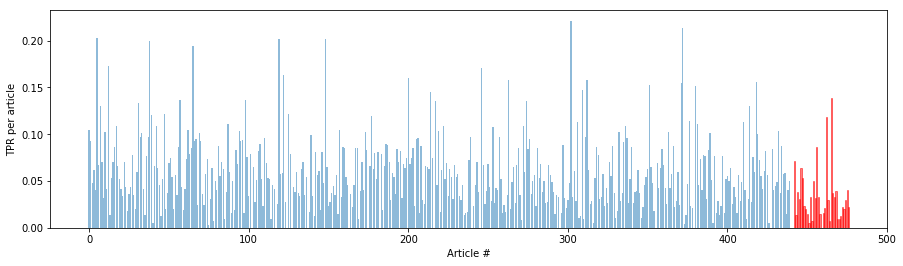

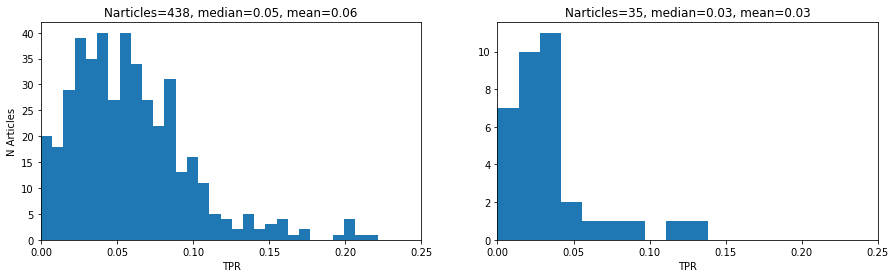

In [257]:
myvar = TPR0
varname = 'TPR'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
set(ax['ax1'].set_xlim(0,0.25));
set(ax['ax2'].set_xlim(0,0.25));



## Plot FPR

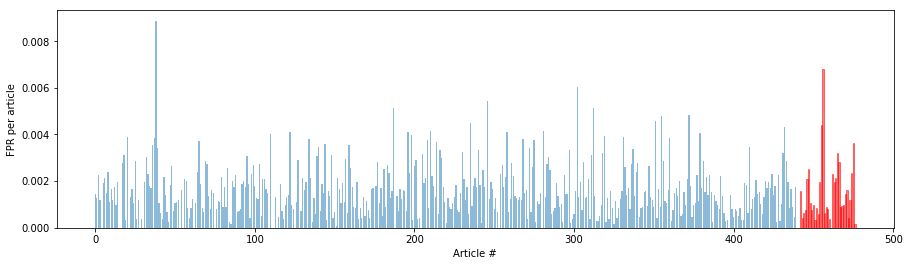

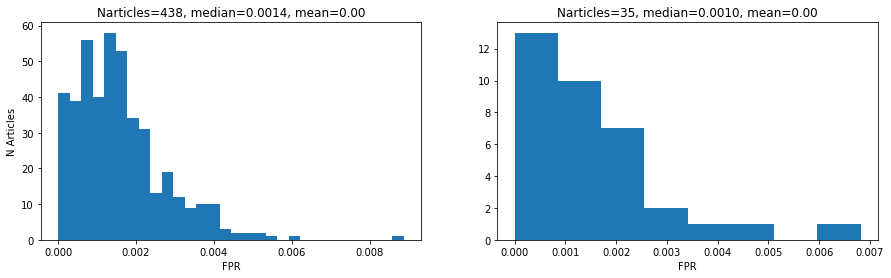

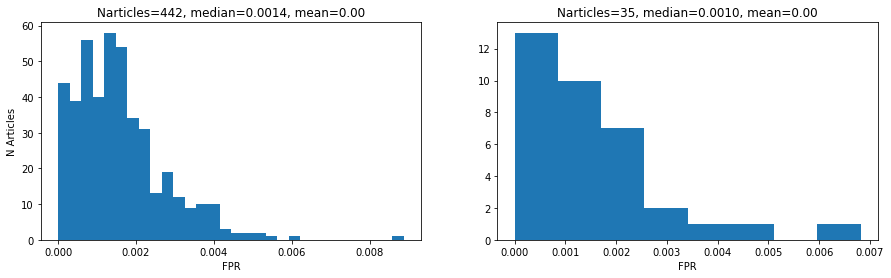

In [272]:
myvar = FPR0
varname = 'FPR'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

def plothist_train_dev2(myvar,Ntrain,Ndev,xlabel='value',ylabel='N Articles',devbins=30):
    # Import fig stuff
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    import statistics

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(15, 4));
    ax1.hist(myvar[0:Ntrain-1], bins=30);  # arguments are passed to np.histogram
    ax1.set_title("Narticles={}, median={}, mean={}".format(str(Ntrain),'{0:.4f}'.format(statistics.median(myvar[0:Ntrain-1])),'{0:.2f}'.format(statistics.mean(myvar[0:Ntrain-1]))));
    ax1.set_ylabel('N Articles');
    ax1.set_xlabel(xlabel);

    ax2.hist(myvar[Ntrain:], bins=devbins);  # arguments are passed to np.histogram
    ax2.set_title("Narticles={}, median={}, mean={}".format(str(Ndev),'{0:.4f}'.format(statistics.median(myvar[Ntrain:])),'{0:.2f}'.format(statistics.mean(myvar[Ntrain:]))));
    ax2.set_xlabel(xlabel);
    return {'ax1': ax1, 'ax2':ax2}


# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
ax = plothist_train_dev2(myvar,Ntrain,Ndev,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Plot ACC

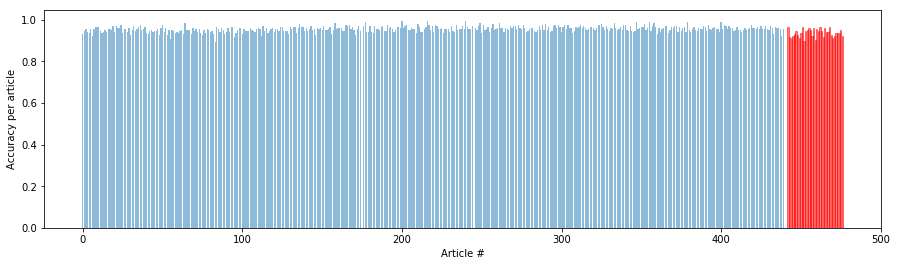

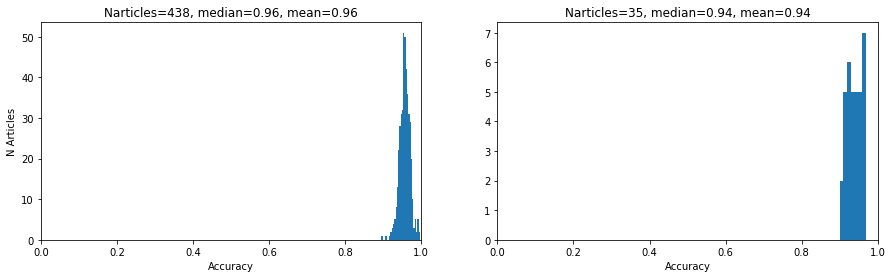

In [119]:
myvar = ACC0
varname = 'Accuracy'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
set(ax['ax1'].set_xlim(0,1));
set(ax['ax2'].set_xlim(0,1));



## Plot True positives per sentence

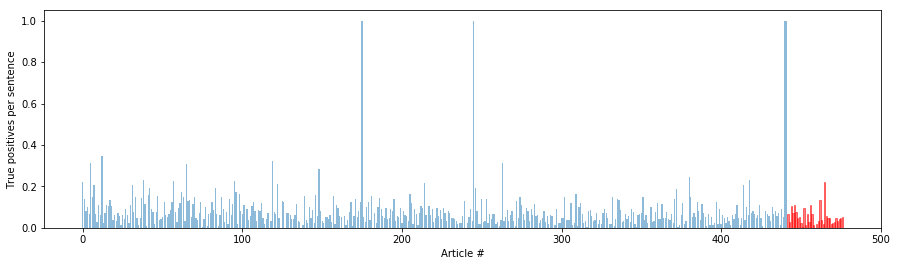

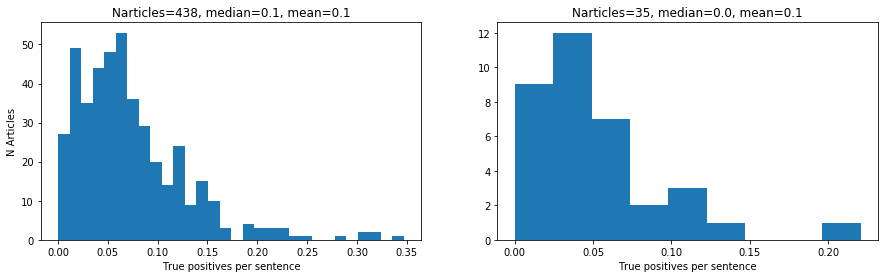

In [40]:
myvar = TPpersent0
varname = 'True positives per sentence'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Plot False positives per sentence

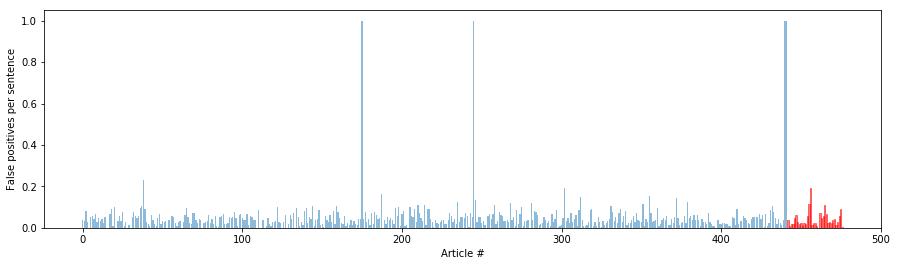

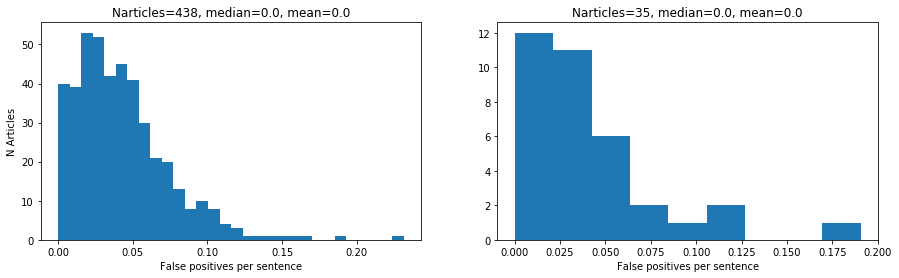

In [41]:
myvar = FPpersent0
varname = 'False positives per sentence'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Find articles containing a lot of true positives

In [265]:

# Inds of all articles >0.4 TPR
inds = [i for i,x in enumerate(TPR0) if x >=0.08]

# Inds of all articles >0.4 TPR and in dev dataset
inds = [i for i,x in enumerate(TPR0) if x >=0.08 and x < 1.0 and i > Ntrain and i not in abads]

print(len(inds))
chosen_ind = inds[0]
print('Article #{}'.format(str(i)))
print(arts[chosen_ind]['title'])
print('True positive rate: {}'.format(str(TPR0[chosen_ind])))

3
Article #476
Black_Death
True positive rate: 0.08641975308641975


In [266]:
# Pull out sample paragraph
a = arts[chosen_ind]
print(a['title'])

# AllenNLP results
words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
# tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

# Ground truth
blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]

Black_Death


In [267]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
The				The
Black				Black
Death				Death
is				is
thought				thought
to				to
have				have
originated				originated
in				in
the				the
arid				arid
plains				plains
of				of
______				Central
______				Asia
,				,
where				where
it				it
then				then
travelled				travelled


## Ground truth blanked

In [269]:
# Blanked text
# print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(set(myanswers))

Answers:
{'17th', 'population', 'Y.', 'account', '1500', 'bad', '100–106', 'Alexandre', '22', 'East', 'northwest', 'Gasquet', '1908', 'genetic', '1720', 'Italian', 'bubonic', 'Jani', '1823', 'marginal', 'Yersinia', 'anthrax', 'Pontanus', '15', 'clergy', 'much', '80', '1331', '2011', 'merchant', 'J.I.', 'China', 'faster', '1.7', 'fleas', 'Miasma', 'France', 'Smithfield', 'Silk', 'air', '40,000', '90', 'trade', 'Scandinavia', 'areas', 'branches', 'corpses', 'half', 'Road', 'north', 'autumn', 'Germany', 'significance', 'form', 'epidemiological', 'figures', '95', 'Half', 'England', 'Asia', '2010', '1377', 'amended', 'ships', '25', 'Constantinople', '19th', 'million', 'spring', '1338–39', 'third', 'infected', 'Hong', 'mors', 'theory', 'Plague', 'pestis', '1654', 'dating', 'Yersin', '1349', 'heavens', 'traders', 'percent', 'Genoese', 'Kong', 'plague', 'confirmed', 'commonly', 'Central', 'century', 'northwestern', '1850', '5', 'October', '1347', '1350', 'Beg', '38–41', 'atra', 'Sicily', '100,

In [271]:
# Blanked text
# print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(set(myanswers))

Answers:
{'1347', 'Beg', 'Alexandre', 'pestis', 'Twigg', 'Yersin', 'Graham', 'Y.', '40,000', 'Yersinia', '1.7', 'million', '100,000', 'Jani'}


# All paragraphs - compare blanks

In [114]:
# Initialize stuff
TPR0 = []
FPR0 = []
ACC0 = []
Nsentences0 = []
TP0 = []
FP0 = []
FN0 = []
TN0 = []
TPpersent0 = []
FPpersent0 = []
abads = []
indices = {'i':[],'j':[],'k':[]}

art = arts[:]


# Only track true positives and false positive to avoid having to deal with other annoying edge cases
i=-1
k=-1
Ntrainp = 0
Ndevp=0
for a in art:
    i=i+1
    j=-1
    for p in a['paragraphs']:
        j=j+1
        k=k+1
        if i < Ntrain: Ntrainp=Ntrainp+1;
        else: Ndevp = Ndevp+1
        # AllenNLP results
        words = [w for w in p['allenNER']['words'].split()]
        tags = [t for t in p['allenNER']['tags'].split()]
        tags = [not t == '0' for t in tags]   # Convert to binary

        # Ground truth
        blank_classification = [bc for bc in p['blank_classification']]
        blank_classification = [b == 1 for b in blank_classification] # Convert to binary

        Nsentences2 = len(text2sentences(words2text(words)))

        sbc = sum(blank_classification)
        st = sum(tags)
        if sbc == 0:
            #print("Warning article {}, paragraph P{} contains {} ground truth blanks and {} tags. Likely bad".format(str(i),str(j),str(sbc),str(st)))

            # Make up some dummy values so don't confuse for a REAL outlier in plots. Should just drop this data in the future
            # This is ok because we'll skip them later if want to do stats - that's what bads is for
            TPR = 0.7
            FNR = 0.7
            ACC = 0.7
            TP = 100
            FP = 100
            FN = 100
            TN = 100
            TPpersent = 1
            FPpersent = 1
            abads.append(k)       # kth paragraph is bad
        else:
            TP = sum([b and t for b,t in zip(blank_classification,tags)])
            FP = sum([not b and t for b,t in zip(blank_classification,tags)])
            FN = sum([b and not t for b,t in zip(blank_classification,tags)])
            TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
#             ACC = (TP+TN)/(TP+FP+FN+TN)
            ACC = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

            # Sensitivity, hit rate, recall, or true positive rate
            TPR = TP/(TP+FN)
#             # Specificity or true negative rate
#             TNR = TN/(TN+FP) 
#             # Precision or positive predictive value
#             PPV = TP/(TP+FP)
#             # Negative predictive value
#             NPV = TN/(TN+FN)
#             # Fall out or false positive rate
#             FPR = FP/(FP+TN)
            # False negative rate
            FNR = FN/(TP+FN)
#             # False discovery rate
#             FDR = FP/(TP+FP)

            # Per sententance values
            TPpersent = TP / Nsentences2
            FPpersent = FP / Nsentences2
    
        TPR0.append(TPR)
        FPR0.append(FPR)
        ACC0.append(ACC)
        TP0.append(TP)
        FP0.append(FP)
        FN0.append(FN)
        TN0.append(TN)
        TPpersent0.append(TPpersent)
        FPpersent0.append(FPpersent)
        indices['i'].append(i)
        indices['j'].append(j)
        indices['k'].append(k)



In [115]:
FPR0[0:10]

[0.0021082220660576245,
 0.0021082220660576245,
 0.0021082220660576245,
 0.0021082220660576245,
 0.0021082220660576245,
 0.0021082220660576245,
 0.0021082220660576245,
 0.0021082220660576245,
 0.0021082220660576245,
 0.0021082220660576245]

In [116]:
# # # Plot the histogram without containing any bads
# Calculate how this affects Ntrain / Ndev
Ntrainp_bad = len([b for b in abads if b < Ntrainp])
Ndevp_bad = len([b for b in abads if b >= Ntrainp])


In [118]:
print(Ntrainp)
print(Ndevp)
print(Ntrainp_bad)
print(Ndevp_bad)
max(abads)
len(FN0)

x = []
for a in abads:
    x.append(TPR0[a])


19035
1204
1383
13


## Plot TPR

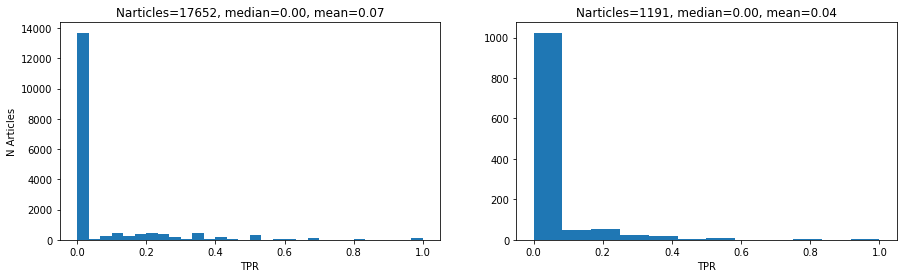

In [119]:
myvar = TPR0
varname = 'TPR'

# Plot bargraph (Don't plot figure for each paragraph!)
# plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrainp-Ntrainp_bad,Ndevp-Ndevp_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Find paragraphs containing a lot of true positives

In [251]:

# Inds of all articles >0.4 TPR
inds = [i for i,x in enumerate(TPR0) if x >=0.6]

# Inds of all articles >0.4 TPR and in dev dataset
inds = [i for i,x in enumerate(TPR0) if x >=0.4 and x < 1.0 and i > Ntrainp and i not in abads]

print(len(inds))
chosen_ind = inds[0]
i = indices['i'][chosen_ind]
j = indices['j'][chosen_ind]
k = indices['k'][chosen_ind]
print('Article #{} paragraph #{}'.format(str(i),str(j)))
print(arts[i]['title'])
print('True positive rate: {}'.format(str(TPR0[chosen_ind])))

25
Article #442 paragraph #11
Normans
True positive rate: 0.5714285714285714


In [252]:
# Pull out sample paragraph
p = arts[i]['paragraphs'][j]

# AllenNLP results
words = p['allenNER']['words'].split()
# tags = p['allenNER']['tags'].split()
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = p['blank_classified_allen']

# Ground truth
blank_classification = p['blank_classification']

In [253]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
______				______
______				______
,				,
an				an
other				other
Norman				Norman
adventurer				adventurer
previously				previously
elevated				elevated
to				to
the				the
dignity				dignity
of				of
count				count
of				of
Apulia				Apulia
as				as
the				the
result				result
of				of


## Ground truth blanked

In [249]:
# Blanked text
print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(myanswers)

______ ______ was descended from Huguenot refugees, as was ______ ______, who signed the Articles of Confederation for South Carolina; Jack Jouett, who made the ride from Cuckoo Tavern to warn Thomas Jefferson and others that Tarleton and his men were on their way to arrest him for crimes against the king; Francis Marion, and a number of other leaders of the American Revolution and later statesmen. The last active Huguenot congregation in North America worships in ______, South Carolina, at a church that dates to 1844. The Huguenot Society of America maintains Manakin Episcopal Church in Virginia as an historic shrine with occasional services. The Society has chapters in numerous states, with the one in ______ being the largest.
Answers:
['Paul', 'Revere', 'Henry', 'Laurens', 'Charleston', 'Texas']


In [250]:
# Blanked text
print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(myanswers)

______ ______ was descended from Huguenot refugees, as was ______ ______, who signed the Articles of Confederation for South Carolina; Jack Jouett, who made the ride from Cuckoo Tavern to warn Thomas Jefferson and others that Tarleton and his men were on their way to arrest him for crimes against the king; Francis Marion, and a number of other leaders of the American Revolution and later statesmen. The last active Huguenot congregation in North America worships in Charleston, South Carolina, at a church that dates to 1844. The Huguenot Society of America maintains Manakin Episcopal Church in Virginia as an historic shrine with occasional services. The Society has chapters in numerous states, with the one in Texas being the largest.
Answers:
['Paul', 'Revere', 'Henry', 'Laurens']


In [174]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [175]:
print(ACC)
print(ACC2)
print(TP)
print(FP)

0.9255813953488372
0.9255813953488372
3
0


In [176]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [177]:
print(TPR)
print(FPR)

0.15789473684210525
0.0
